In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from glob import glob

import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from sklearn.preprocessing import minmax_scale
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

rng = np.random.RandomState(42)

In [7]:
channel_colors = ("Purple", "Green", "Orange")
n_chans = len(channel_colors)
n_samples = 100
eeg = rng.normal(size=(n_samples, n_chans))

n_lags = 11

conditions = ["sentence\nonset", "word\nonset", "content\nword?", "frequency"]

onsets = {"sentence\nonset": (2,),
          "word\nonset": (2, 10, 25, 59, 72, 80),
          "content\nword?": (2, 10, 25, 59, 72, 80),
          "frequency": (2, 10, 25, 59, 72, 80)}

values = {"sentence\nonset": (1,),
          "word\nonset": (1, 1, 1, 1, 1, 1),
          "content\nword?": (False, False, False, False, True, True),
          "frequency": (-1., .7, -.2, .4, -.1, .2)}

effect_onsets = {"sentence\nonset": 5,
                 "word\nonset": 6,
                 "content\nword?": 5,
                 "frequency": 7}

xs = list()
for ii, cond in enumerate(conditions):
    ts = np.ones((len(values[cond]), n_lags)) * np.array(values[cond])[:, np.newaxis]
    xs.append(sparse.diags(ts, onsets[cond], shape=(n_lags, n_samples)))
X = sparse.vstack(xs).tocsc().T.toarray()

all_channel_weights = {"sentence\nonset": (1+rng.beta(2, 2, 3)) ** 3,
                 "word\nonset": (1+rng.beta(2, 2, 3)) / 5,
                 "content\nword?": (1+rng.beta(2, 2, 3)) ** 2.5,
                 "frequency": (1+rng.beta(2, 2, 3)) ** 3}

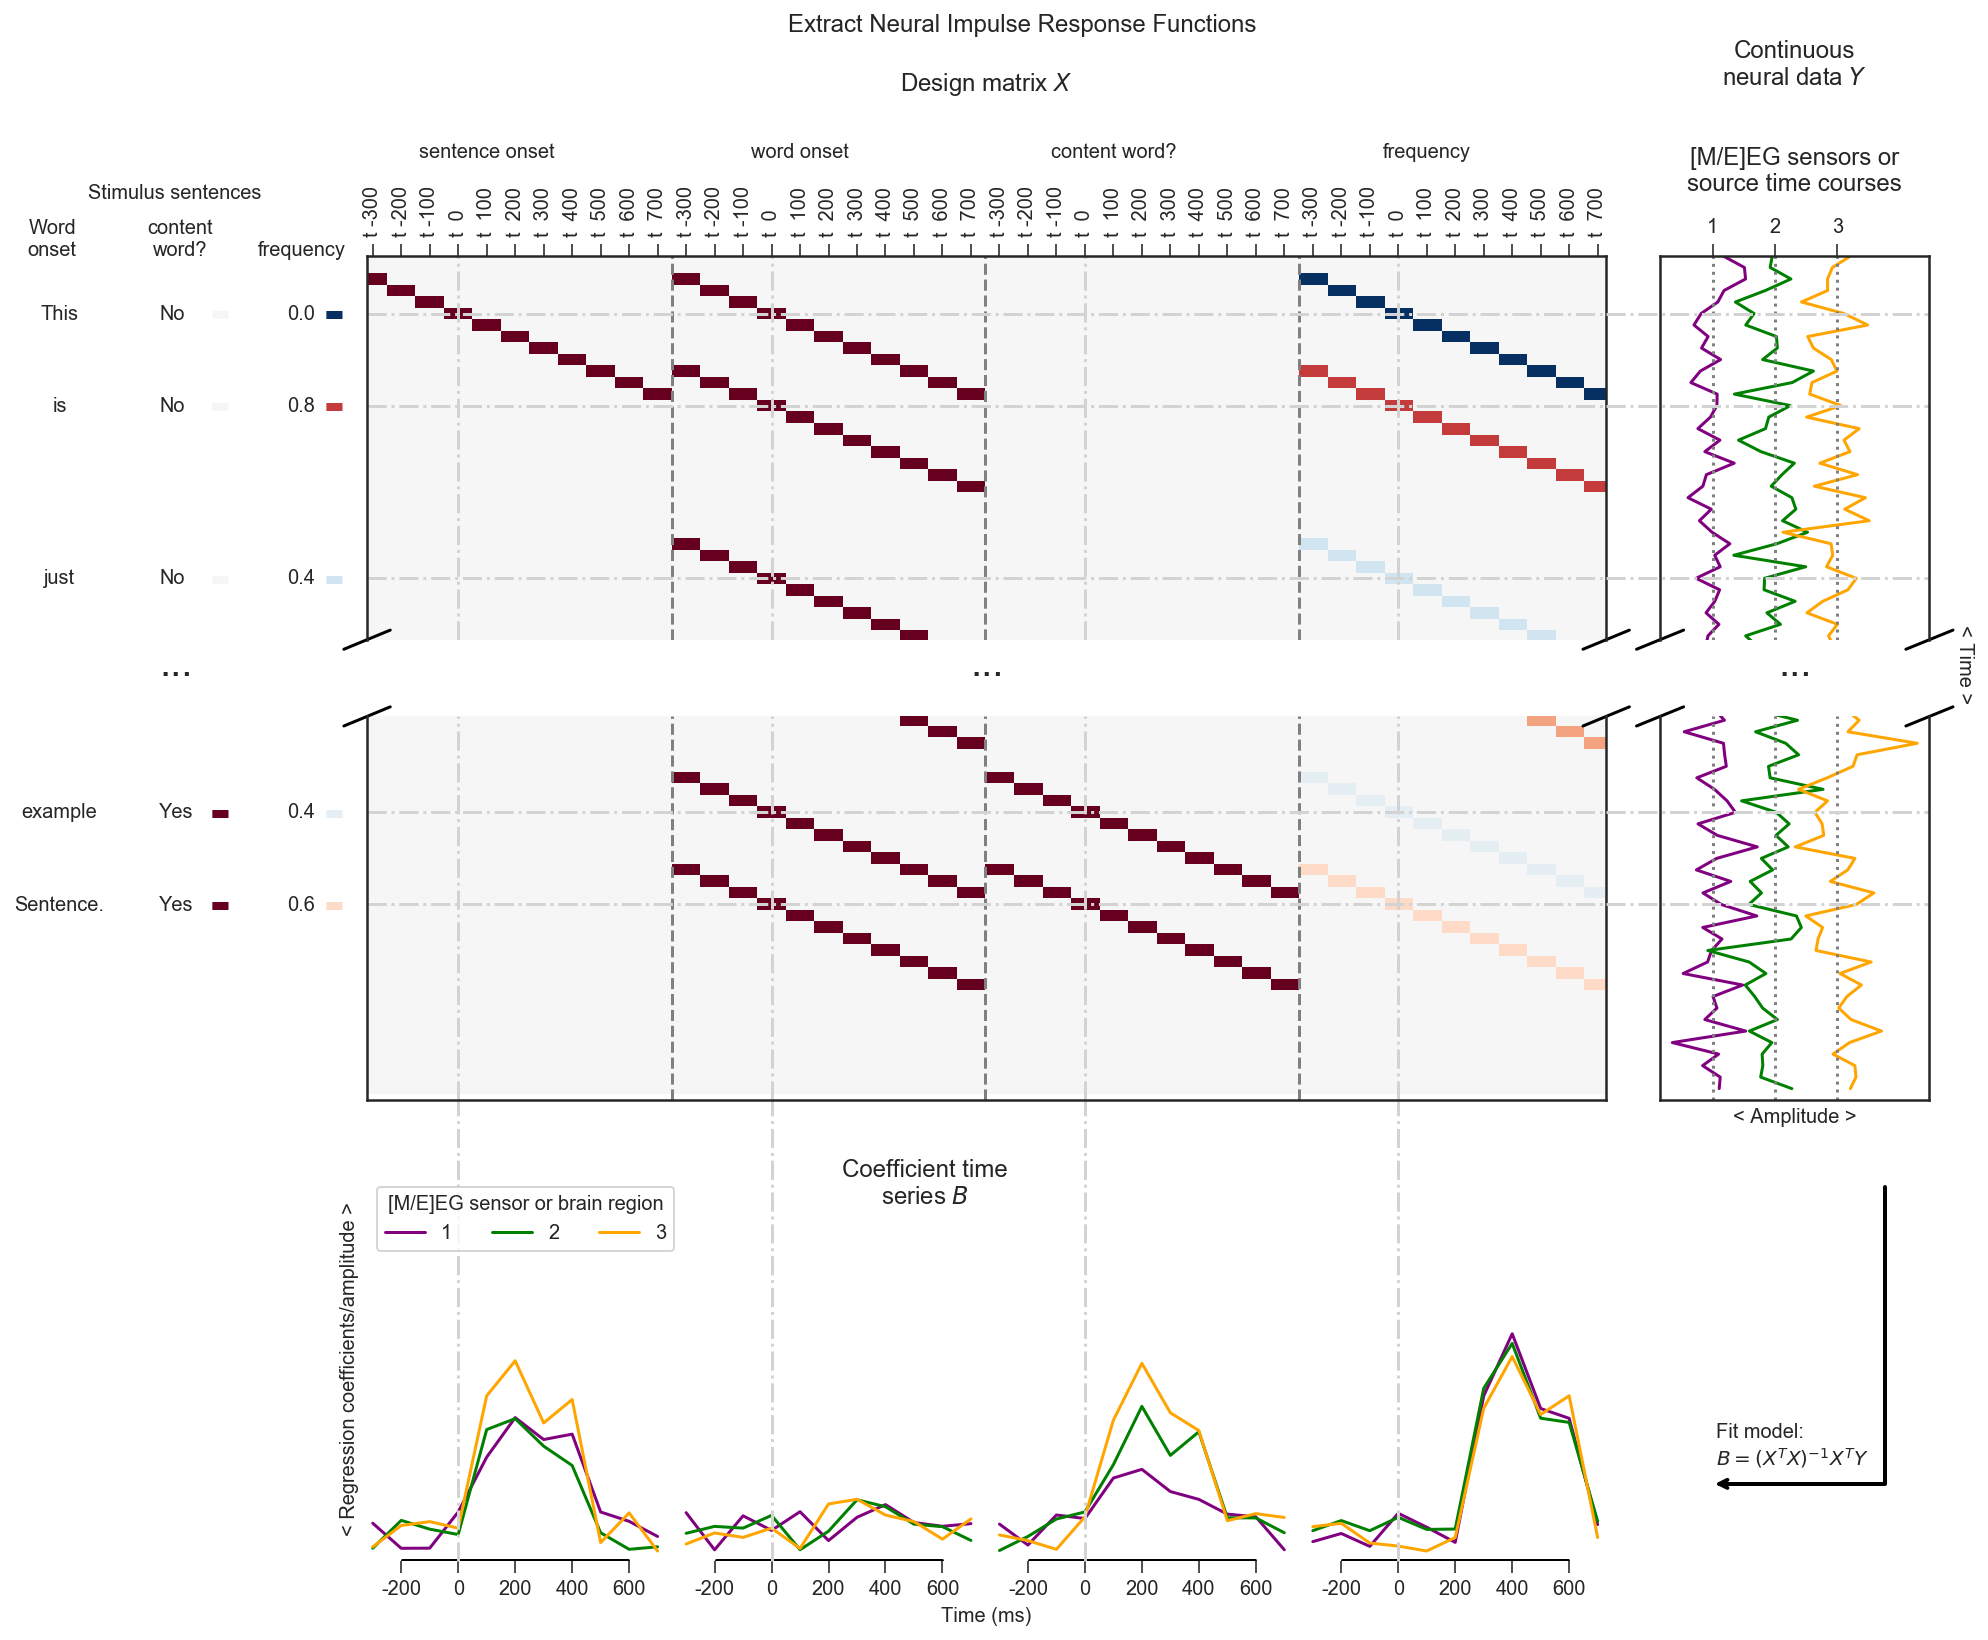

In [8]:
shape = (3, 5)


fig = plt.figure()
fig.set_size_inches((14, 12))

###################################################################################
##########                Coef ER[P/F]s                         ###################
###################################################################################
xticks = [-200, 0, 200, 400, 600] * len(conditions)
coef_axes = plt.subplot2grid(shape=shape, loc=(2, 0), rowspan=1, colspan=4)
tss = list()
for col, cond in enumerate(conditions):
    channel_weights = all_channel_weights[cond]
    ts2 = np.zeros(n_lags)
    onset = effect_onsets[cond]
    ts2[onset] += .5
    ts2[onset-1:onset+3] += 1
    tss.extend(np.arange(1, 10, 2) + (col * n_lags))
    times = np.arange(n_lags) + (col * n_lags)
    for jj, (color, channel_weight) in enumerate(zip(channel_colors, channel_weights)):
        kwargs = dict()
        if cond == conditions[-1]:
            kwargs["label"] = str(jj + 1)
        coef_axes.plot(times, (ts2 * channel_weight) + (rng.random_sample(n_lags)) * 1.5,
                  c=color, **kwargs)
    ymin = coef_axes.get_ylim()[0]
    coef_axes.plot((1.033 + (n_lags * col), 8.975 + (n_lags * col)),
                   (ymin * .9, ymin * .9), color="black")
    coef_axes.set_ylim(ymin=ymin)

coef_axes.set_ylim(ymax=14)
coef_axes.set_xlim(-.2, times[-1] + .3)
coef_axes.set_xticks(tss)
coef_axes.set_xticklabels(xticks * 4)
for v in np.array(tss)[1::5]:
    coef_axes.axvline(v, ymin=0, ymax=1.2,
                      linestyle="-.", color="lightgrey", clip_on=False)
for loc in ["top", "left", "right", "bottom"]:
    coef_axes.spines[loc].set_visible(False)
coef_axes.set_yticks([])
coef_axes.set_ylabel("< Regression coefficients/amplitude >")
coef_axes.set_xlabel("Time (ms)")
coef_axes.set_title("Coefficient time\nseries $B$", x=.45, y=.9)

coef_axes.legend(loc="upper left", title="[M/E]EG sensor or brain region",
                 ncol=3, frameon=True)

###################################################################################
###############                Design image                  ######################
###################################################################################
im_cmap = "RdBu_r"

ax_design = plt.subplot2grid(shape=shape, loc=(0, 0), rowspan=1, colspan=4)
ax_design.set_xticks(np.arange(4 * n_lags))
ax_design.set_xticklabels(["t " + (" " if ii > 2 else "") + 
                           str(100 * (ii - 3))
                           for _ in range(4) for ii in range(n_lags)] + [""],
                          rotation=90)
ax_design.set_title("Design matrix $X$", y=1.4)
ax_design.xaxis.tick_top()
im = ax_design.imshow(X, aspect="auto", cmap=im_cmap,
                      vmin=-1, vmax=1, interpolation="nearest")

ax_design2 = plt.subplot2grid(shape=shape, loc=(1, 0), rowspan=1, colspan=4)
ax_design2.set_xticks(np.arange(4 * n_lags))        
im2 = ax_design2.imshow(X, aspect="auto", cmap=im_cmap, vmin=-1, vmax=1,
                       interpolation="nearest", origin='upper')
ax_design2.set_xticks([])

for ii, ax_ in enumerate((ax_design, ax_design2)):
    ax_.set_yticks([])
    ax_.set_yticks(np.array(onsets[conditions[1]]) + 3)
    ax_.set_yticklabels([])
    ax_.yaxis.tick_right()
    for cond, name in enumerate(conditions):
        if ii == 0:
            ax_.text((cond * n_lags) + 4, -8.5, name.replace('\n', ' '), horizontalalignment='center')
        if name != conditions[-1]:
            ax_.axvline((.955 + cond) * n_lags, linestyle="--", color="grey")
        ax_.axvline((cond * n_lags) + 3., linestyle="-.", color="lightgrey")
    for onset in onsets[conditions[1]]:
        ax_.axhline(onset + 3, linestyle="-.", color="lightgrey")

words = ["Den", "Ton", "gab", 'Künstler', "seinem", "Gehilfen."]
words = ["This", "is", "just", 'an', "example", "Sentence."]

ax_design2.invert_yaxis()

ax_ = ax_design
ax_.text(43.5 - 54.75, 0, "Word\nonset", rotation=0, horizontalalignment='center')
ax_.text(48 - 54.75, 0, "content\nword?", rotation=0, horizontalalignment='center')
ax_.text(52.25 - 54.75, 0, "frequency", rotation=0, horizontalalignment='center')

import matplotlib as mpl
clrs = [.5 + np.array(values["frequency"]) / 2]
clrs2 = (np.array(values["content\nword?"], dtype=float)/2) +.5

for ii, (word, onset, content, p, color, color2) in enumerate(zip(
                words, onsets["word\nonset"],
                values["content\nword?"],
                minmax_scale(values["frequency"], (0, .8)),
                mpl.cm.RdBu_r(clrs)[0],
                mpl.cm.RdBu_r(clrs2))):
    if word == 'an':
        continue
    ax_.text(x=44.5 - 55.5, y=onset+3.5, s=word, horizontalalignment='center')
    ax_.text(x=48. - 55.5, y=onset+3.5, s="Yes" if content else "No")
    ax_.text(x=52.5 - 55.5, y=onset+3.5, s=round(p, 1))
    ax_.text(53.75 - 55.5, onset + 4.5, '-', color=color, fontsize=30, fontweight='bold')
    ax_.text(49.75 - 55.5, onset + 4.5, '-', color=color2, fontsize=30, fontweight='bold')
    if word == 'just':
        ax_ = ax_design2

ax_design.text(47.5 - 55, 36.5, "...", rotation=0, fontsize=20)
ax_design.text(45 - 55, -5, "Stimulus sentences")

ax_design2.set_ylim(n_samples, n_samples * (2/3))
ax_design.set_ylim(n_samples / 3, 0)

ax_design2.set_xlim(-.2, times[-1] + .3)
ax_design.set_xlim(-.2, times[-1] + .3)

###################################################################################
#########                Horizontal [M/E]EG data                  #################
###################################################################################
times = np.arange(n_samples)
data_axes = list()
for jj, lims in enumerate(([(0, 1/3), (2/3, 1)])):
    ax_data = plt.subplot2grid(shape=shape, loc=(jj, 4), rowspan=1, colspan=1)
    data_axes.append(ax_data)
    for ii, (eeg_, color) in enumerate(zip(eeg.T, channel_colors)):
        ax_data.plot(eeg_ + (ii * 3), times, c=color)
        ax_data.axvline(ii * 3, linestyle=":", color="grey")
    if jj == 0:
        ax_data.set_title("Continuous\nneural data $Y$\n\n\n[M/E]EG sensors or\nsource time courses\n\n ")
        ax_data.set_xticks(np.arange(len(channel_colors)) * 3)
        ax_data.set_xticklabels(np.arange(len(channel_colors)) + 1)
    else:
        ax_data.set_xlabel("< Amplitude >")
        ax_data.set_xticks([])
    ax_data.xaxis.tick_top()
    ax_data.invert_yaxis()
    ax_data.set_yticks([])
    for onset in onsets[conditions[1]]:
        if onset + 3 in np.array(times)[int(lims[0] * len(times)):int(lims[1] * len(times))]:
            ax_data.axhline((onset + 3), xmin=-.2, xmax=1.,
                            linestyle="-.", color="lightgrey", clip_on=False)
    ax_data.set_ylim(*[len(times) * lim for lim in reversed(lims)])
ax_data.text(+11.66, len(times) * .6,
             "< Time >", rotation=270)


###################################################################################
##########                Style data and design                  ##################
###################################################################################
axes_pairs = ((data_axes, 3.5), ((ax_design, ax_design2), .75))
for (ax, ax2), fac in axes_pairs:
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    # how big to make the diagonal lines; in axes coordinates
    d = .025  

    ax.plot((-d * fac, +d * fac), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d * fac, 1 + d * fac), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d * fac, +d * fac), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - (d * fac), 1 + (d * fac)), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    ax.set_xlabel("...", rotation=0, fontsize=20)

def con_style(ax, connectionstyle, x1, y1, x2, y2, label=None):
    if label is None:
        label = connectionstyle
    ax.annotate("",
                xy=(x1, y1), xycoords='data',
                xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->", #linestyle="dashed",
                                color="k",
                                shrinkA=5, shrinkB=5,
                                patchA=None,
                                patchB=None,
                                connectionstyle=connectionstyle,
                                linewidth=2
                                ),
                )

ax_arrow = plt.subplot2grid(shape=shape, loc=(2, 4), rowspan=1, colspan=1)
ax_arrow.set_xlim((-0.1, 1.1))
ax_arrow.set_ylim((-0.1,.9))
ax_arrow.axis('off')

connectionstyle="angle,angleA=-90,angleB=180,rad=0"
con_style(ax_arrow, connectionstyle,  .1, 0.1, 0.9, .9)
ax_arrow.text(.15, .15, "Fit model:\n$B=(X^TX)^{-1}X^TY$");

fig.suptitle("Extract Neural Impulse Response Functions", x=.45, y=1.02);
#fig.savefig("/Users/jona/Dropbox/manuscripts/review_langcogproc/rerp_expl_review.pdf", bbox_inches="tight");

In [9]:
all_dfs = []
conc = '/Users/jona/tools/lexical_norms/Concreteness_ratings_Brysbaert_et_al_BRM.txt'
conc = pd.read_csv(conc, sep="\t").set_index("Word")
all_dfs.append(conc)
#moesm = '/Users/jona/tools/lexical_norms/13428_2016_718_MOESM1_ESM_Birchenough.csv'
#moesm = pd.read_csv(moesm, encoding="latin-1").set_index("Word")
#all_dfs.append(moesm)
brm = '/Users/jona/tools/lexical_norms/BRM-emot-submit.csv'
brm = pd.read_csv(brm).set_index("Word")
all_dfs.append(brm)

aoa = '/Users/jona/tools/lexical_norms/aoa_plus_pos.csv'
aoa = pd.read_csv(aoa).set_index("Word")
aoa = aoa.drop([c for c in aoa.columns if "Unnamed" in c], axis=1)
all_dfs.append(aoa)

In [10]:
import warnings
warnings.simplefilter("ignore")

rename_dict = {"V.Mean.Sum": "Valence", "A.Mean.Sum": "Arousal", "D.Mean.Sum": "Dominance",
               "Conc.M": "Concreteness", "SUBTLEX": "Frequency", "Rating.Mean": "AoA", "pos": "POS"}
df_lexnorm = brm.join(conc).join(aoa)
df_lexnorm = df_lexnorm.dropna()[list(rename_dict.keys())]

if False:
    from pyxdameraulevenshtein import (damerau_levenshtein_distance,
                                   normalized_damerau_levenshtein_distance,
                                   damerau_levenshtein_distance_ndarray,
                                   normalized_damerau_levenshtein_distance_ndarray)
    words = [str(w) for w in df_lexnorm.index]
    print("doing OLD20 for {} words ...".format(len(words)))
    for ii, w1 in enumerate(words): 
        if (ii % 1000) == 0:
            print(", ", end="")
        df_lexnorm.loc[w1, "OLD20"] = np.mean(sorted(damerau_levenshtein_distance_ndarray(w1, np.array(words)))[-21:-1])
else:
    old20 = pd.read_csv(
    "/Users/jona/tools/lexical_norms/old20.csv",
    index_col=0, header=None, names=["Word", "OLD20"])
    df_lexnorm["OLD20"] = old20

if False:
    df_lexnorm["logFreq"] = np.log(df_lexnorm["Frequency"])
    del df_lexnorm["logFreq"]

df_lexnorm = df_lexnorm.rename(rename_dict, axis=1)
df_lexnorm["Word Length"] = df_lexnorm.index.str.len()
df_lexnorm["Content Word"] = [w in {"NOUN", "ADJ", "VERB", "ADV"} for w in df_lexnorm["POS"]]
#df_lexnorm = pd.concat((df_lexnorm, pd.get_dummies(df_lexnorm["POS"])), axis=1)
df_lexnorm = df_lexnorm.dropna()

In [11]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def wcorr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [12]:
from itertools import combinations
cols = [c for c in df_lexnorm.columns if c != "POS"]

arr = np.zeros((len(cols), len(cols)))
for one, two in combinations(cols, 2):
    r = wcorr(df_lexnorm[one].values, df_lexnorm[two].values, df_lexnorm["Frequency"].values)
    ii, jj = cols.index(one), cols.index(two)
    arr[ii, jj] = r
    arr[jj, ii] = r

df_wcorr = pd.DataFrame(arr, index=cols, columns=cols)
df_unwcorr = df_lexnorm.corr(method="spearman")

In [13]:
arr = np.array(
    [[ 0.26162007,  0.27184155,  0.25827908,  0.1621562 ,  1.        ,
         0.1621562 ,  0.25827908,  0.27184155,  0.26162007],
       [ 0.25828636,  0.25707955,  0.25878612,  0.25759018,  1.        ,
         0.25759018,  0.25878612,  0.25707955,  0.25828636]])

pcts = np.array([          np.nan,  116.55140085,  129.93169421,  104.2622738 ,
         81.89392206,   60.89097222,   45.39730574,   34.80297707,
         29.45850074,   27.60905954,   26.78064436,   29.07891938,
         34.75114719,   38.18181818,   46.86658977,   48.19705434,
         54.5570427 ,   52.08643815,   59.92876224,   62.01469045])
pcts = pd.Series(pcts)  # stored here because it takes a long time to recalculate them

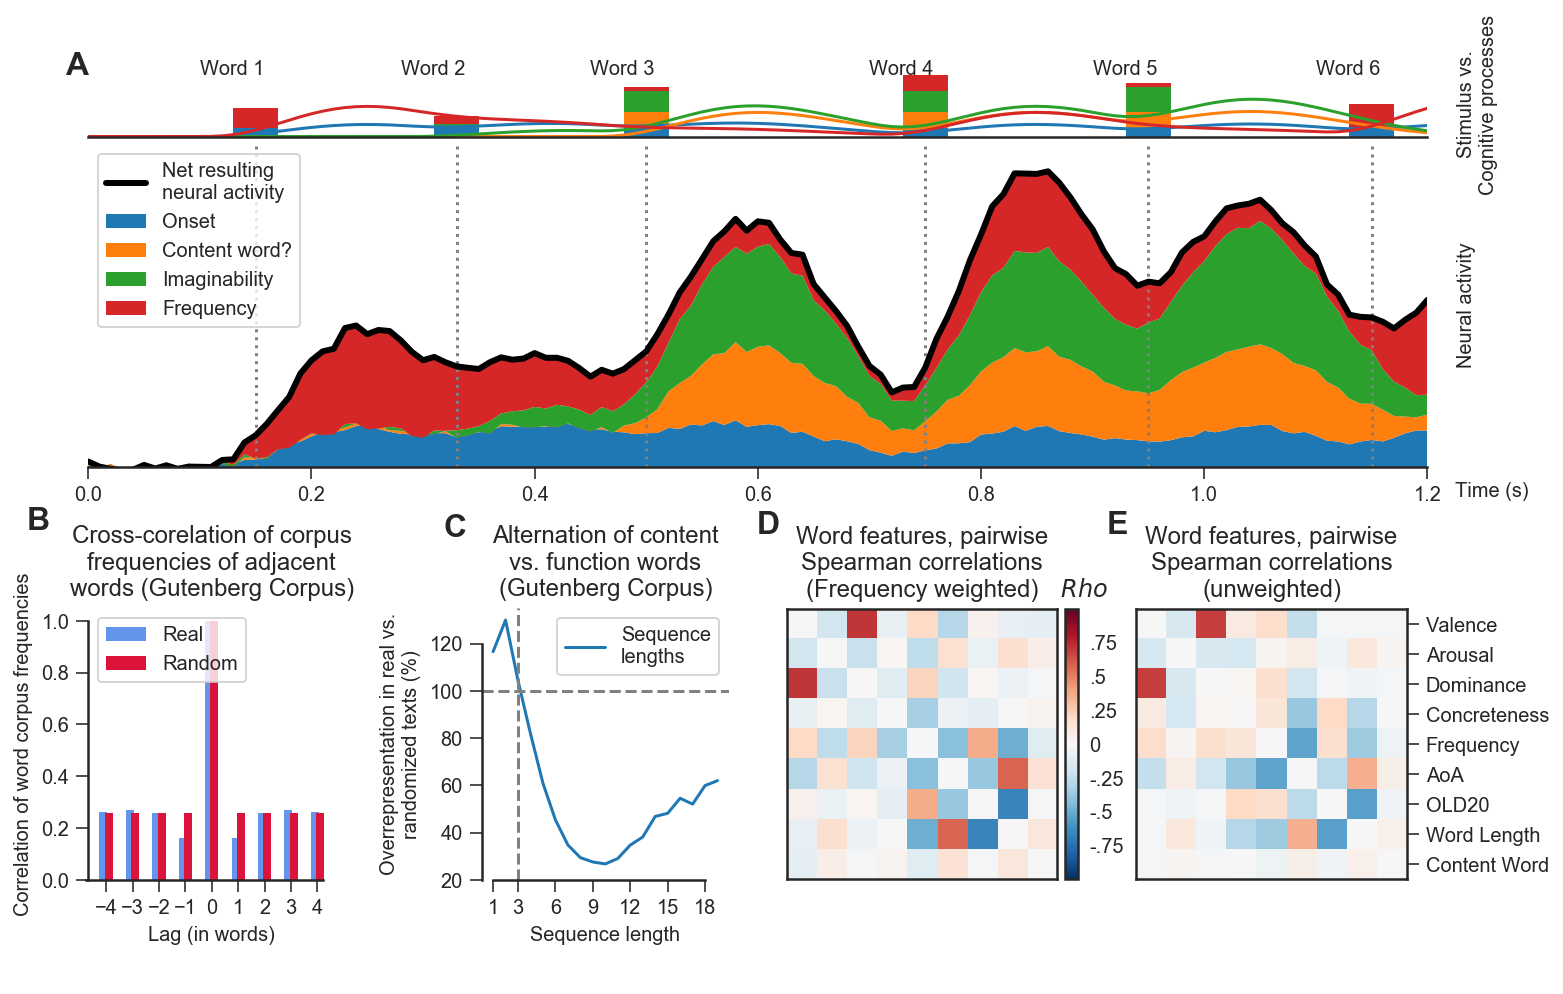

In [35]:
f = plt.figure()
f.set_size_inches((12, 8))

####################################
#        Time Series (top)         #
####################################
from scipy import stats
from sklearn.preprocessing import minmax_scale
times = np.arange(0, 1, .02)
irf = stats.beta.pdf(times, 4, 8) * 2

t_onsets = [10, 28, 45, 70, 90, 110]
vals = np.array([[2, 0, 0, 5], [2, 0, 1, 2], [2, 4, 5, 1],
                 [2, 4, 5, 4], [2, 4, 6, 1], [2, 0, 0, 6], [2, 0, 4, 2]])

n_times = int((max(t_onsets) + len(times)))
series = np.zeros((4, n_times))
noise = (np.random.random((4, n_times)) - .5) * 2

ax = plt.subplot2grid(shape=(2, 3), loc=(0, 0), rowspan=1, colspan=3)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
ts_ax = divider.append_axes("top", size="20%", pad=0.05)

for ii, (t, vals_) in enumerate(zip(t_onsets, vals), 1):
    series[:, t:t+len(irf)] += np.array([irf * val for val in vals_])
    kwargs = dict()
    ax.axvline(t + 5, 0, 1, linestyle=":", color="grey", **kwargs)
    bottom=0
    for color, val in zip(["C0", "C1", "C2", "C3"], vals_):
        ts_ax.bar(t + 5, (val * 4), bottom=bottom, color=color, width=4)
        bottom += val * 4
    ts_ax.text(t, 60, "Word " + str(ii))
ts_ax.yaxis.set_label_position("right")
ts_ax.set_ylabel("\nStimulus vs.\nCognitive processes")

ts_ax.text(-2, 60, "A", weight="bold", size=16)

ax.yaxis.set_label_position("right")
ax.set_ylabel("\nNeural activity")

ax.stackplot(np.arange(n_times), np.abs(series) + noise,
             labels=["Onset", "Content word?", "Imaginability", "Frequency"])
ax.set_xlim(0, 120)
for loc in ["top", "right", "left"]:
    ax.spines[loc].set_visible(False)
ax.set_yticks([])
ax.plot((series + noise).sum(0), color="k", label="Net resulting\nneural activity", linewidth=3);

for series_ in series:
    ts_ax.plot(series_);
ts_ax.set_xlim(0, 120)
for loc in ["top", "right", "left"]:
    ts_ax.spines[loc].set_visible(False)
ts_ax.set_yticks([])
ts_ax.set_xticks([])

ax.legend(frameon=True)
ax.set_ylim(-.01, series.sum(0).max() * 1.1)
ax.set_xticklabels([0., .2, .4, .6, .8, 1., 1.2])

ax.set_xlabel("")
ax.text(122.5, -9, "Time (s)")

ax = plt.subplot2grid(shape=(2, 4), loc=(1, 3), rowspan=1, colspan=1)
df_ = df_lexnorm.corr(method="spearman")
vals = df_.values

vals[np.diag(np.ones(len(df_.columns))).astype(bool)] = 0

im = ax.imshow(vals, cmap="RdBu_r", vmin=-1, vmax=1)
ax.yaxis.tick_right()
ax.set_yticks(range(len(df_.columns)))
ax.set_yticklabels(df_.columns);
ax.set_xticks([]);
ax.set_title("Word features, pairwise\nSpearman correlations\n(unweighted)")
ax.text(-1.5, -3, "E", weight="bold", size=16)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
cbar.axis("off")

ax = plt.subplot2grid(shape=(2, 4), loc=(1, 2), rowspan=1, colspan=1)
df_ = df_wcorr
vals = df_.values

vals[np.diag(np.ones(len(df_.columns))).astype(bool)] = 0

im = ax.imshow(vals, cmap="RdBu_r", vmin=-1, vmax=1)
ax.yaxis.tick_right()
ax.set_yticks([]);
ax.set_xticks([]);
ax.set_title("Word features, pairwise\nSpearman correlations\n(Frequency weighted)")
ax.text(-1.5, -3, "D", weight="bold", size=16)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cbar)
cbar.set_yticks([-.75, -.5, -.25, 0, .25, .5, .75])
cbar.set_yticklabels(["", "-.75", "-.5", "-.25", "0", ".25", ".5", ".75"])
cbar.yaxis.set_ticks_position('none') 
cbar.set_title("    $Rho$")
cbar.tick_params(pad=-.5)

ax = plt.subplot2grid(shape=(2, 4), loc=(1, 1), rowspan=1, colspan=1)

pcts.plot(ax=ax, label="Sequence\nlengths")
ax.legend(frameon=True)
ax.set_xticks([1, 3, 6, 9, 12, 15, 18])
ax.axvline(3, color="grey", linestyle="--")
ax.set_ylabel("Overrepresentation in real vs.\nrandomized texts (%)")
ax.set_xlabel("Sequence length")
ax.axhline(100, color="grey", linestyle="--")
ax.set_title("Alternation of content\nvs. function words\n(Gutenberg Corpus)")

ax.text(-3, 165, "C", weight="bold", size=16)

ax.set_yticks((20, 40, 60, 80, 100, 120))

for loc in ["top",  "right"]:
    ax.spines[loc].set_visible(False)
ax.spines['left'].set_bounds(20, 120)
ax.spines['bottom'].set_bounds(1, 18)

divider = make_axes_locatable(ax)

dummy = divider.append_axes("bottom", size="20%", pad=0.05)
dummy.axis('off')
dummy = divider.append_axes("top", size="20%", pad=0.05)
dummy.axis('off')

dummy = divider.append_axes("left", size="15%", pad=0.05)
dummy.axis('off')

ax = plt.subplot2grid(shape=(2, 4), loc=(1, 0), rowspan=1, colspan=1)

lags = np.arange(-4, 5)
ax.bar(lags - .1, arr[0, :], width=.3, label="Real", color="cornflowerblue")
ax.bar(lags + .1, arr[1, :], width=.3, label="Random", color="crimson")
ax.legend(loc=2, frameon=True)
ax.set_title("Cross-corelation of corpus\nfrequencies of adjacent\nwords (Gutenberg Corpus)")
ax.text(-7, 1.35, "B", weight="bold", size=16)

ax.set_ylabel("Correlation of word corpus frequencies")
ax.set_xlabel("Lag (in words)")
ax.set_xticks((-4, -3, -2, -1, 0, 1, 2, 3, 4))
for loc in ["top",  "right"]:
    ax.spines[loc].set_visible(False)
ax.spines['left'].set_bounds(0, 1)
ax.spines['bottom'].set_bounds(-4.75, 4.2)

divider = make_axes_locatable(ax)

dummy = divider.append_axes("bottom", size="20%", pad=0.05)
dummy.axis('off')
dummy = divider.append_axes("top", size="20%", pad=0.05)
dummy.axis('off')


dummy = divider.append_axes("right", size="15%", pad=0.05)
dummy.axis('off')

f.savefig("/Users/jona/Dropbox/manuscripts/review_langcogproc/figs/stimprob.pdf", bbox_inches="tight")

# Simulation of recovery of overlapping impulses from noisy data

In [1]:
# construct impulses
ev_len = 100

i1 = np.hstack(
    [np.zeros(40),
     (1-np.linspace(-1, 1, ev_len // 2) ** 2),
     np.zeros(10)]
)
i1_ = np.hstack(
    [np.zeros(30),
     (1-np.linspace(-1, 1, ev_len // 2) ** 2),
     np.zeros(20)]
)
i1 *= i1_

i2 = np.hstack(
    [np.zeros(10),
     (1-np.linspace(-1, 1, ev_len // 2) ** 2),
     np.zeros(40)]
)

i3 = np.hstack(
    [np.zeros(25),
     (1-np.linspace(-1, 1, ev_len // 2) ** 2),
     np.zeros(25)]
) * -1

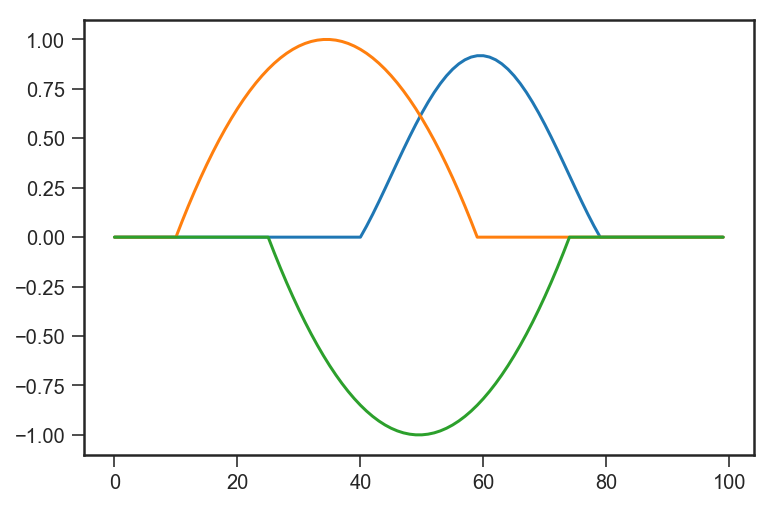

In [2]:
plt.plot(np.array((i1, i2, i3)).T)

In [5]:
n_events = 200
n_times = ((ev_len + 1) * n_events)
n_features = 2

def make_events(ev_times, ev_len=ev_len, n_features=n_features):
    events = np.zeros((ev_times.max() + (ev_len * 2), n_features))
    events[ev_times, 0] = 1
    events[ev_times[::2], 1] = 1
    return events

ev_times_isolated = np.arange(n_events) * (ev_len + 1)
ev_times_overlap = (np.cumsum(ev_len + (np.random.randn(n_events) * (ev_len / 2)))).astype(int)#np.random.randint(0, high=n_times - ev_len, size=n_events)

events_isolated = make_events(ev_times_isolated)
events_overlap = make_events(ev_times_overlap)

probs = (minmax_scale(np.gradient(ev_times_overlap) / ev_len) / 2) + ((ev_times_isolated % 2) / 2)
add_effect = probs > np.random.random(size=len(probs))
noise_feature = np.zeros(len(events_overlap))
noise_feature[ev_times_overlap[add_effect]] = 1
events_colinear = np.hstack((events_overlap.copy(), noise_feature[:, np.newaxis]))

In [65]:
snr = 3
y_noise = np.random.randn(max((max(ev_times_isolated), max(ev_times_overlap))) + (ev_len * 3)) / snr

def make_y(events, y_noise=y_noise, signals=(i2, i1, i3)):
    impulses = np.sum([np.convolve(events_, imp)
        for events_, imp in zip(events.T, signals)], 0)
    y = y_noise.copy()
    y[:len(impulses)] += impulses
    return y

all_events = np.array((events_isolated, events_overlap, events_colinear))
Ys = np.array([make_y(events_) for events_ in all_events])

In [7]:
# ERPs
def do_averaging(y, events, ev_len=ev_len):
    res1 = np.array([y[t:t+ev_len] for t in np.where(events[:, 0])[0]]).mean(0)
    res2 = np.array([y[t:t+ev_len] for t in np.where(events[:, 1])[0]]).mean(0)
    diff = res2 - res1
    diff2 = res1 - diff
    return np.array([diff2, diff * 2]).T

# regression
from scipy.linalg import toeplitz
def do_regression(y, events=None, ev_len=ev_len):
    # we are hand-rolling a function here instead of using a preconstructed one
    # to keep things clean, but note this is a highly inefficient implementation

    # construct the design matrix
    x_ = (toeplitz([1] + [0] * (ev_len-1)))

    X = np.zeros((len(y), ev_len * events.shape[-1]))
    for t, evs_ in enumerate(events):
        if any(evs_.astype(bool)):
            for ii, ev_ in enumerate(evs_):
                X[t:t+ev_len, (ii*ev_len):((ii+1) * ev_len)] += x_ * ev_

    # the actual regression
    reg = (np.eye(ev_len*len(evs_)) * .1)
    b_ = np.linalg.inv(X.T @ X + reg) @ (X.T @ y)
    b = b_.T.reshape((ev_len, len(evs_)), order="F")
    return b

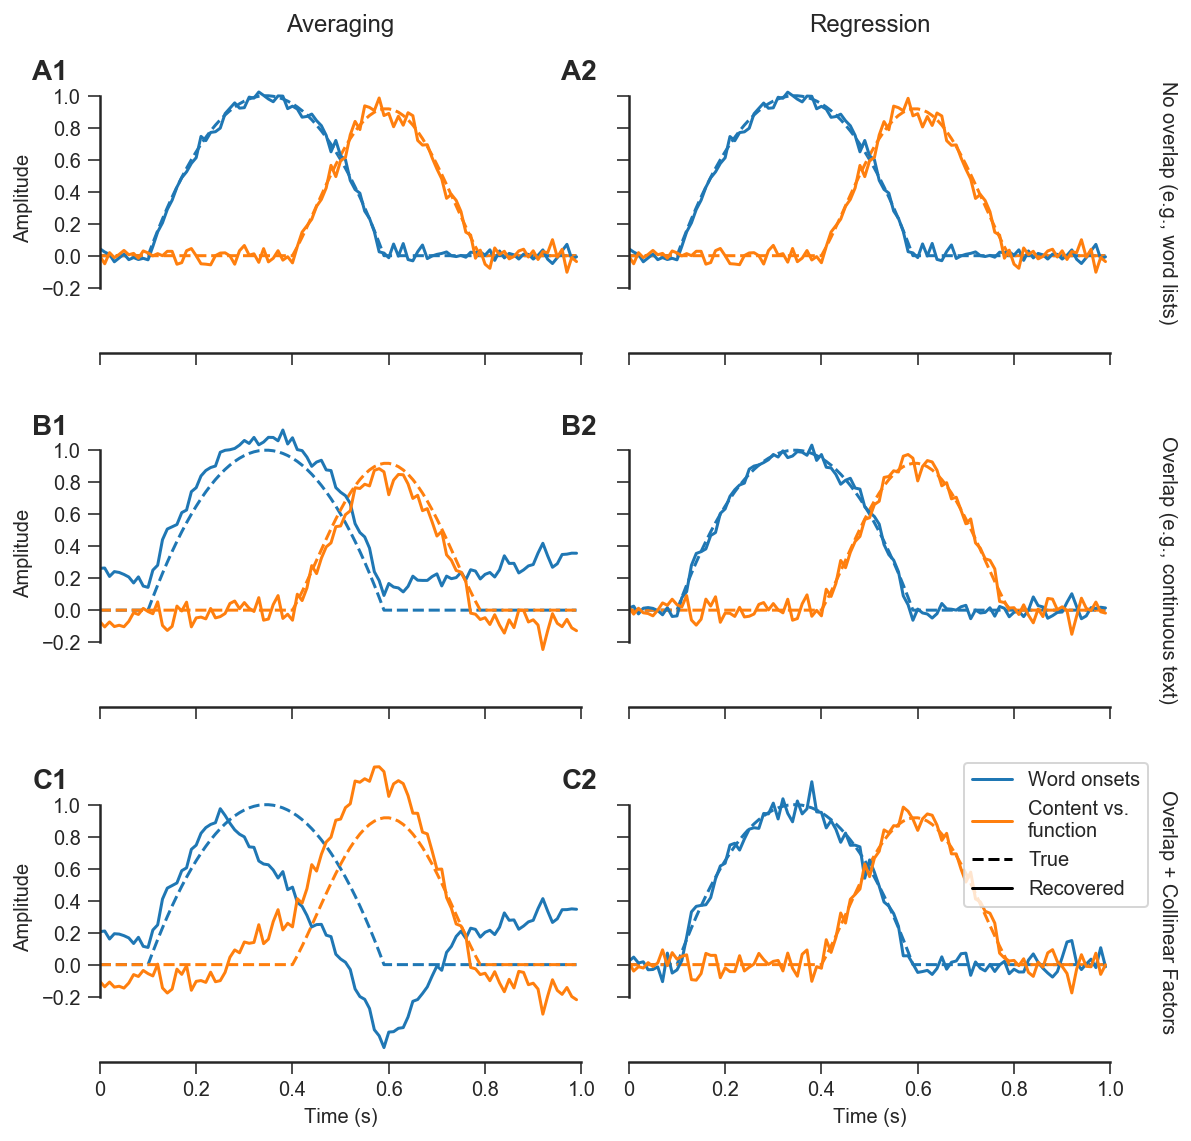

In [8]:
# for drawing the legend
dummies = []

from matplotlib.lines import Line2D
dummies.append(Line2D([], [], label="Word onsets", color="C0"))
dummies.append(Line2D([], [], label="Content vs.\nfunction", color="C1"))
dummies.append(Line2D([], [], label="True", color="k", linestyle="--"))
dummies.append(Line2D([], [], label="Recovered", color="k"))

f, axes = plt.subplots(ncols=2, nrows=3, sharey=True, sharex=True)
f.set_size_inches((8, 8))

for ii, ax in enumerate(axes.flatten()):
    letter = "ABC"[ii // 2] + str(1+ii % 2)
    name = "Regression" if bool(ii % 2) else "Averaging"
    Y = Ys[ii // 2]
    events = all_events[ii // 2]
#    (Y, ev_times, snd, events) = Ys[ii // 2]
    ylab = ["No overlap (e.g., word lists)",
            "Overlap (e.g., continuous text)",
            "Overlap + Collinear Factors"][ii // 2]
    
    if name == "Regression":
        arr_ = do_regression(Y, events)
    else:
        arr_ = do_averaging(Y, events)
        #arr_[:, 1] -= arr_[:, 0]#.mean(0)
    ax.plot(i2, color="C0", linestyle="--", label="Word onsets\n(original)")
    ax.plot(i1, color="C1", linestyle="--", label="Content words\n(original)")

    ax.plot(arr_[:, 0], color="C0", label="Word onsets\n(recovered)")
    ax.plot(arr_[:, 1], color="C1", label="Content words\n(recovered)")

    for loc in ["top",  "right"]:
        ax.spines[loc].set_visible(False)
    ax.set_yticks([-.2, 0, .2, .4, .6, .8, 1.])
    ax.spines['left'].set_bounds(-.2, 1.)
    ax.spines['bottom'].set_bounds(0, 100)
    ax.set_xlim((0, 100))
    ax.set_xticklabels([0, .2, .4, .6, .8, 1.])
    if ax.is_last_row():
        ax.set_xlabel("Time (s)")
    if ax.is_first_row():
        ax.set_title(name)
    ax.text(-14, 1.1, letter, weight="bold", size=14)
    if ax.is_first_col():
        ax.set_ylabel("Amplitude")
    if ax.is_last_col():
        ax.text(110, 1, ylab, rotation=270)

        
ax.legend(dummies,
          [l.get_label() for l in dummies],
          frameon=True, ncol=1,  loc='upper right', bbox_to_anchor=(1.1, 1.)
         )

plt.tight_layout()
#f.suptitle("Simulation: recovery of impulses from continuously overlapping data")
#f.savefig("/Users/jona/Dropbox/manuscripts/review_langcogproc/figs/simul_recovery.pdf", bbox_inches="tight")

In [66]:
def make_events_problems(ev_times, ev_len=ev_len, n_features=n_features):
    events = np.zeros((ev_times.max() + (ev_len * 2), n_features))
    events[ev_times, 0] = 1
    for ii in range(1, n_features):
        events[ev_times, ii] = np.random.randn(len(ev_times))
    return events

In [239]:
ymin, ymax = -.5, 1.1

def style_plot(ax, letter, ymin=ymin, ymax=ymax):
    for loc in ["top",  "right"]:
        ax.spines[loc].set_visible(False)
    ax.set_yticks([-.4, 0,  .4, .8])
    ax.spines['left'].set_bounds(-.4, .8)
    ax.spines['bottom'].set_bounds(0, 100)
    ax.set_xlim((0, 100))
    ax.set_xticklabels([0, .2, .4, .6, .8, 1.])
    if ax.is_last_row():
        ax.set_xlabel("Time (s)")
    ax.text(-14, 1.1, letter, weight="bold", size=14)
    if ax.is_first_col():
        ax.set_ylabel("Amplitude")
    if ax.is_last_col():
        ax.text(105, 0.5, "Regression estimates", rotation=270)
    ax.set_ylim(ymin, ymax)

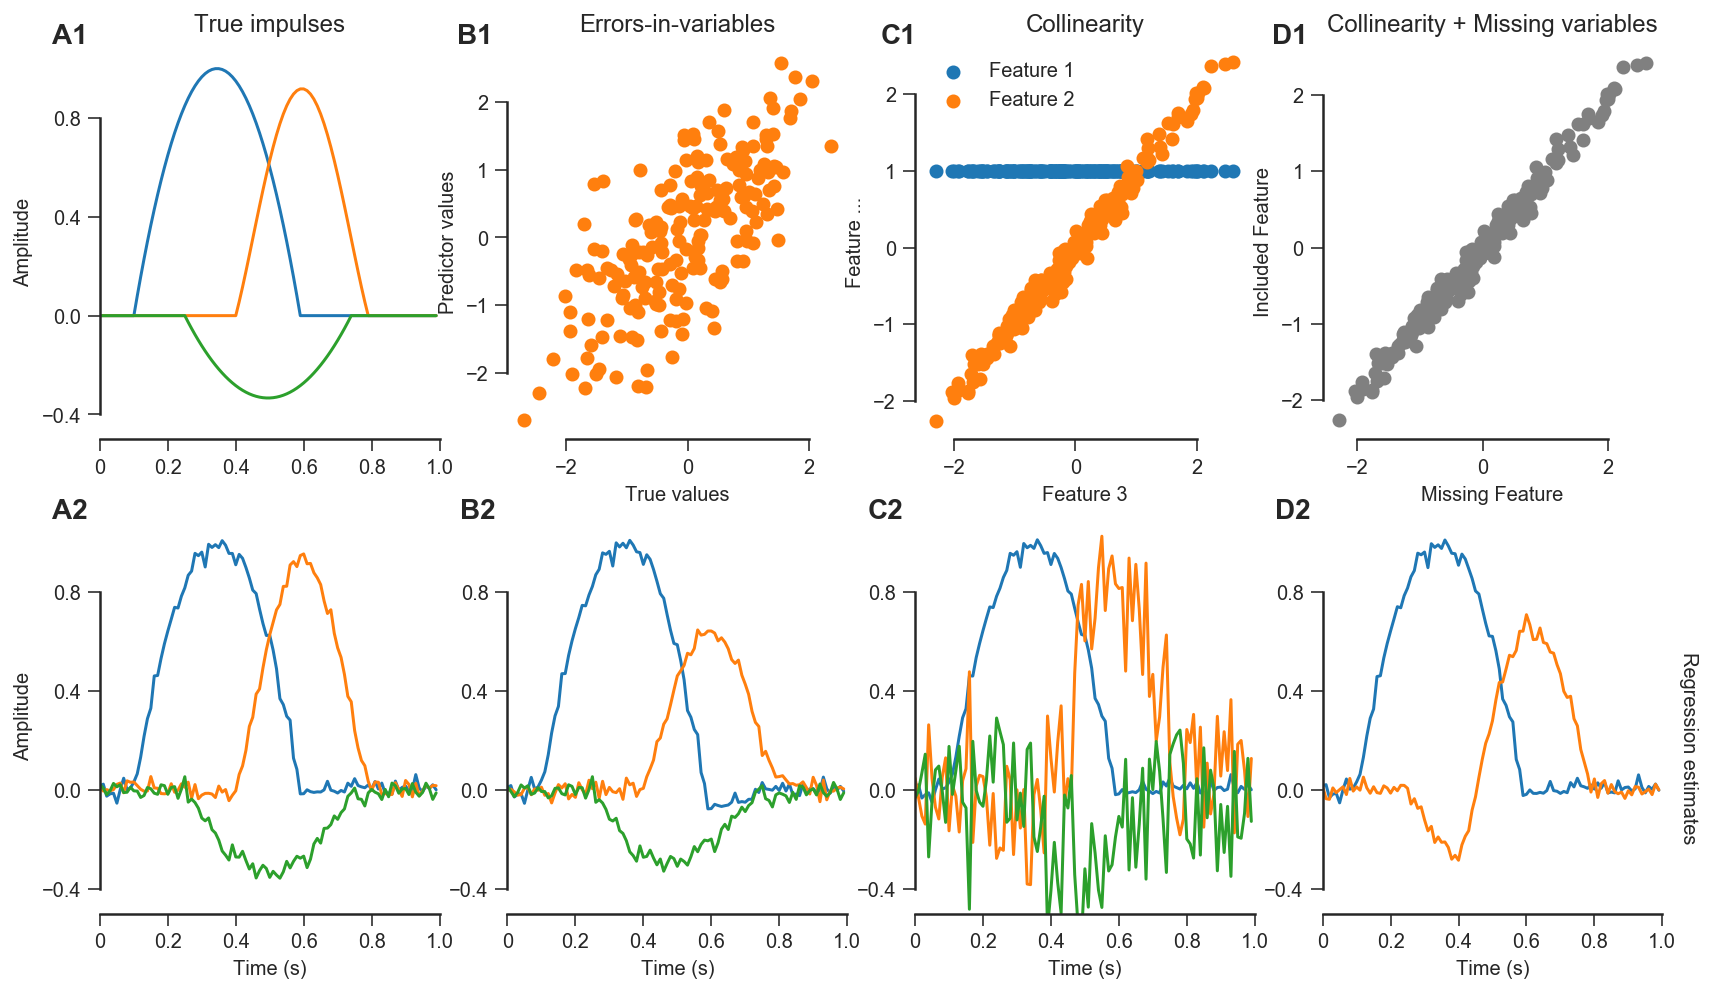

In [258]:
fig, axes = plt.subplots(nrows=2, ncols=4,
#                         sharex=True, sharey=True
                        )
fig.set_size_inches((14, 8))



events_problems = make_events_problems(ev_times_overlap, n_features=3)
events_problems_col = make_events_problems(ev_times_overlap, n_features=3)
inds = np.where(events_problems_col[:, -2]!= 0)[0]
events_problems_col[inds, -1] = events_problems_col[inds, -2] + (np.random.randn(len(inds))/10) 

y_noise = np.random.randn(max((max(ev_times_isolated), max(ev_times_overlap))) + (ev_len * 3)) / snr
Y = make_y(events_problems, signals=np.array((i2, i1, i3 / 3)))

arr_ = do_regression(Y, events_problems)
ax = axes[1, 0]
ax.plot(arr_[:, :])
ax.set_ylim(ymin, ymax)
style_plot(ax, "A2")

ax = axes[0, 0]
ax.plot(np.array((i2, i1, i3 / 3)).T)
ax.set_title("True impulses")
style_plot(ax, "A1")
ax.text(+105, 1.1, "B1", weight="bold", size=14)
ax.text(+230, 1.1, "C1", weight="bold", size=14)
ax.text(+345, 1.1, "D1", weight="bold", size=14)

#axes[0, 0].imshow(get_corrmat(events_problems), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)

fac = 1
inds = np.where(events_problems[:, 1]!= 0)[0]
y_old = events_problems[inds, 1].copy()
events_problems[inds, 1] += (np.random.randn(len(inds)) * fac)
events_problems[inds, 1] *= .8
arr_ = do_regression(Y, events_problems)
ax = axes[1, 1]
ax.plot(arr_[:, :])
style_plot(ax, "B2")
ax = axes[0, 1]
ax.scatter(y_old, events_problems[inds, 1], color="C1")
ax.set_ylabel("Predictor values")
ax.set_xlabel("True values")
for loc in ["top",  "right"]:
    ax.spines[loc].set_visible(False)
ax.set_yticks(([-2, -1, 0, 1, 2]))    
ax.spines['left'].set_bounds(-2, 2)
ax.spines['bottom'].set_bounds(-2, 2)
ax.set_title("Errors-in-variables")
#axes[0, 1].imshow(get_corrmat(events_problems), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)


y_noise = np.random.randn(max((max(ev_times_isolated), max(ev_times_overlap))) + (ev_len * 3)) * fac
Y = make_y(events_problems_col, signals=np.array((i2, i1, i3 / 3)))

arr_ = do_regression(Y, events_problems_col)
ax = axes[1, 2]
ax.plot(arr_[:, :])
style_plot(ax, "C2")

ax = axes[0, 2]
ax.scatter(events_problems_col[inds, -1], events_problems_col[inds, 0], color="C0", label="Feature 1")
ax.scatter(events_problems_col[inds, -1], events_problems_col[inds, 1], color="C1", label="Feature 2")
ax.legend()
ax.set_ylabel("Feature ...")
ax.set_xlabel("Feature 3")
for loc in ["top",  "right"]:
    ax.spines[loc].set_visible(False)
ax.set_yticks(([-2, -1, 0, 1, 2]))    
ax.spines['left'].set_bounds(-2, 2)
ax.spines['bottom'].set_bounds(-2, 2)
ax.set_title("Collinearity")

#axes[0, 2].imshow(get_corrmat(events_problems_col), origin="lower", cmap="RdBu_r", vmin=-1, vmax=1)

arr_ = do_regression(Y, events_problems_col[:, :-1])
ax = axes[1, 3]
ax.plot(arr_[:, :])
style_plot(ax, "D2")


ax = axes[0, 3]
ax.scatter(events_problems_col[inds, -1], events_problems_col[inds, 1], color="grey")
ax.set_ylabel("Included Feature")
ax.set_xlabel("Missing Feature")
for loc in ["top",  "right"]:
    ax.spines[loc].set_visible(False)
ax.set_yticks(([-2, -1, 0, 1, 2]))    
ax.spines['left'].set_bounds(-2, 2)
ax.spines['bottom'].set_bounds(-2, 2)
ax.set_title("Collinearity + Missing variables");

fig.savefig("/Users/jona/Dropbox/manuscripts/review_langcogproc/figs/simul_failures.pdf", bbox_inches="tight")

In [259]:
np.corrcoef(events_problems_col[inds, -1], events_problems_col[inds, 1])

array([[1.        , 0.99336613],
       [0.99336613, 1.        ]])